In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [2]:
df= pd.read_csv('datatraining.txt', sep=",")

In [3]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX,dfY.reindex(columns=df1.columns)])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [4]:
del df['HumidityRatio']

In [5]:
df['Ora'] = df['date']

In [6]:
for inx,item in enumerate(df['Ora']):
    df.at[inx+1,'Ora'] = df.at[inx+1,'Ora'].split(' ')[1]
    df.at[inx+1,'Ora'] = df.at[inx+1,'Ora'].split(':')[0]
    if int(df.at[inx+1,'Ora']) <= 6 :
        df.at[inx+1,'Ora'] = '3'
    elif int(df.at[inx+1,'Ora']) <= 12 :
        df.at[inx+1,'Ora'] = '1'
    elif int(df.at[inx+1,'Ora']) <= 20 :
        df.at[inx+1,'Ora'] = '2'
    else : df.at[inx+1,'Ora'] = '3'

In [7]:
test1= pd.read_csv('datatest.txt', sep=",")

In [8]:
test2= pd.read_csv('datatest2.txt', sep=",")

In [9]:
dates = pd.to_datetime(df['date'], infer_datetime_format=True)
df['day'] = dates.dt.day
df['hour'] = dates.dt.time
df['absH'] = dates.dt.hour

In [10]:
weekend = []
for i in df.day:
    if i == 7 or i == 8:
        weekend.append(1)
    else:
        weekend.append(0)
weekend = pd.Series(weekend)
df['weekend'] = weekend

In [11]:
df.head()

,date,Temperature,Humidity,Light,CO2,Occupancy,Ora,day,hour,absH,weekend
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,1,2,4,17:51:00,17,0.0
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,1,2,4,17:51:59,17,0.0
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,1,2,4,17:53:00,17,0.0
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,1,2,4,17:54:00,17,0.0
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,1,2,4,17:55:00,17,0.0


In [12]:
del df['date']

In [13]:
turn = []
for i in df.absH:
    if i >= 19 and i <= 7:
        turn.append(0)
    else:
        turn.append(1)
turn = pd.Series(turn)
df['out_of_turn'] = turn

In [14]:
df["out_of_turn"].replace(np.nan, 1, inplace= True)

In [15]:
df["weekend"].replace(np.nan, 0, inplace= True)

In [16]:
df = df[['Temperature', 'Light', 'CO2', 'Occupancy', 'day' , 'absH', 'weekend' , 'out_of_turn', ]]

In [17]:
df.head()

,Temperature,Light,CO2,Occupancy,day,absH,weekend,out_of_turn
1,23.18,426.0,721.25,1,4,17,0.0,1.0
2,23.15,429.5,714.00,1,4,17,0.0,1.0
3,23.15,426.0,713.50,1,4,17,0.0,1.0
4,23.15,426.0,708.25,1,4,17,0.0,1.0
5,23.10,426.0,704.50,1,4,17,0.0,1.0


In [18]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

In [19]:
class_name = 'Occupancy'

In [20]:
import sys
sys.path.append('./')

In [21]:
from data_preparation import prepare_dataset

In [22]:
df[class_name].value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

In [23]:
rows2remove = np.random.choice(df[df[class_name] == 1].index, 483 - 50, replace=False)


In [24]:
len(df), len(rows2remove)

(8143, 433)

In [25]:
df.head()

,Temperature,Light,CO2,Occupancy,day,absH,weekend,out_of_turn
1,23.18,426.0,721.25,1,4,17,0.0,1.0
2,23.15,429.5,714.00,1,4,17,0.0,1.0
3,23.15,426.0,713.50,1,4,17,0.0,1.0
4,23.15,426.0,708.25,1,4,17,0.0,1.0
5,23.10,426.0,704.50,1,4,17,0.0,1.0


In [26]:
df2 = df.drop(index=rows2remove, axis=0)
print(len(df2))

7710


In [27]:
print('Dataset shape %s' % Counter(df2[class_name]))

Dataset shape Counter({0: 6414, 1: 1296})


In [28]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [29]:
attributes = [col for col in df.columns if col != class_name]
X = df2[attributes].values
y = df2[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([4490,  907])), (array([0, 1]), array([1924,  389])))

In [32]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.9926502377864246
F1-score [0.99558785 0.97800776]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1924
           1       0.98      0.97      0.98       389

    accuracy                           0.99      2313
   macro avg       0.99      0.98      0.99      2313
weighted avg       0.99      0.99      0.99      2313



In [33]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [34]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

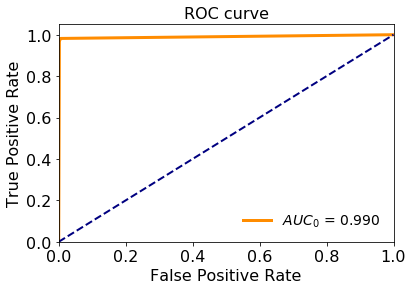

In [35]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9930825767401643
F1-score [0.99585062 0.97922078]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1924
           1       0.99      0.97      0.98       389

    accuracy                           0.99      2313
   macro avg       0.99      0.98      0.99      2313
weighted avg       0.99      0.99      0.99      2313



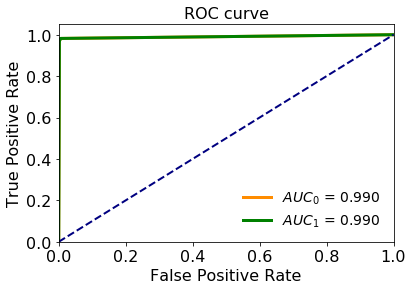

In [36]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

def adjusted_predict(X, thr=0.5):
    y_score = clf.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score])

y_pred = adjusted_predict(X_test, thr=0.8)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, thr = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [37]:
from sklearn.decomposition import PCA

In [38]:
X_train.shape

(5397, 7)

In [39]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

In [40]:
X_pca.shape

(5397, 2)

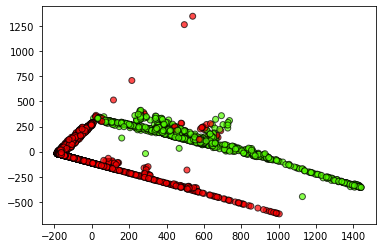

In [41]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [42]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour

In [43]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 907, 1: 907})


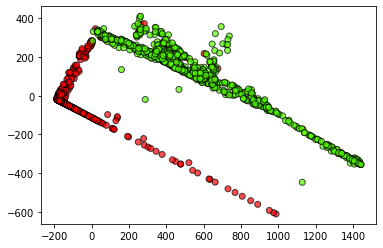

In [44]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9891915261565067
F1-score [0.99346747 0.96871089]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1924
           1       0.94      0.99      0.97       389

    accuracy                           0.99      2313
   macro avg       0.97      0.99      0.98      2313
weighted avg       0.99      0.99      0.99      2313



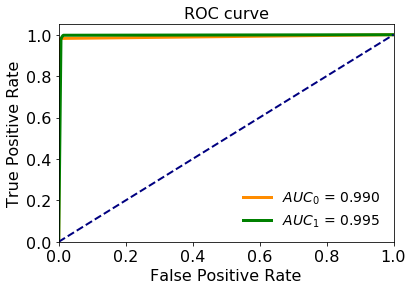

In [45]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [46]:
import warnings
warnings.simplefilter("ignore")

In [47]:
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 907, 0: 58})


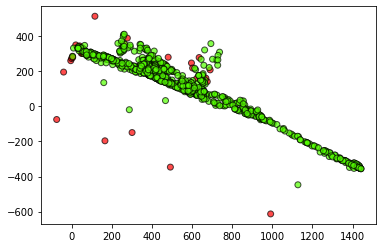

In [48]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9939472546476438
F1-score [0.99636175 0.98200514]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1924
           1       0.98      0.98      0.98       389

    accuracy                           0.99      2313
   macro avg       0.99      0.99      0.99      2313
weighted avg       0.99      0.99      0.99      2313



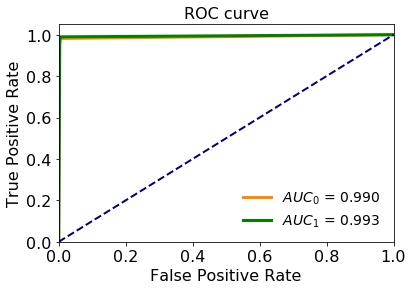

In [49]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [50]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [51]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4490, 1: 4490})


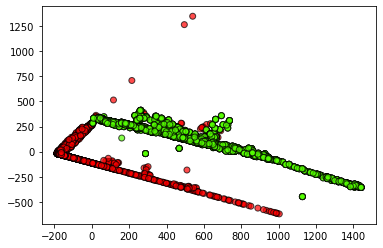

In [52]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.993514915693904
F1-score [0.9960968  0.98084291]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1924
           1       0.97      0.99      0.98       389

    accuracy                           0.99      2313
   macro avg       0.99      0.99      0.99      2313
weighted avg       0.99      0.99      0.99      2313



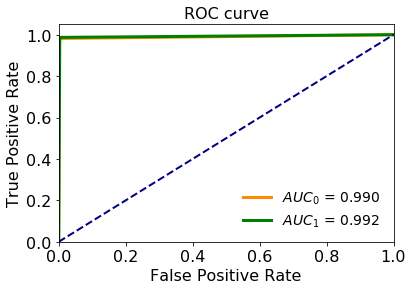

In [53]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [54]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4490, 1: 4490})


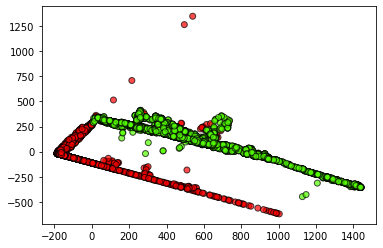

In [55]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9917855598789451
F1-score [0.99505079 0.97585769]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1924
           1       0.96      0.99      0.98       389

    accuracy                           0.99      2313
   macro avg       0.98      0.99      0.99      2313
weighted avg       0.99      0.99      0.99      2313



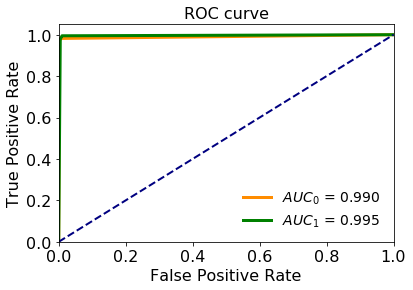

In [56]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# meta cost sesitive classifier

# # Scikit-plot

In [58]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9909946786737618
F1-score [0.99429756 0.97859922]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1924
           1       0.99      0.97      0.98       519

    accuracy                           0.99      2443
   macro avg       0.99      0.98      0.99      2443
weighted avg       0.99      0.99      0.99      2443



In [59]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

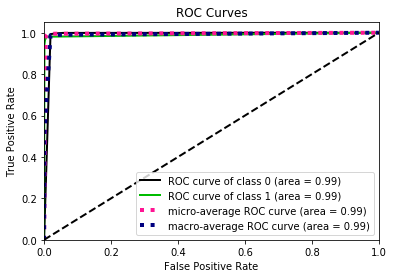

In [60]:
plot_roc(y_test, y_score)
plt.show()

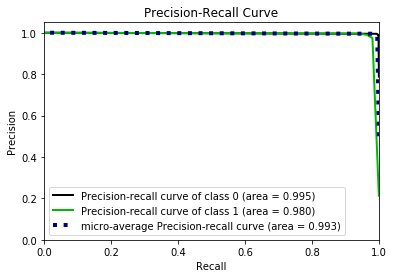

In [61]:
plot_precision_recall(y_test, y_score)
plt.show()

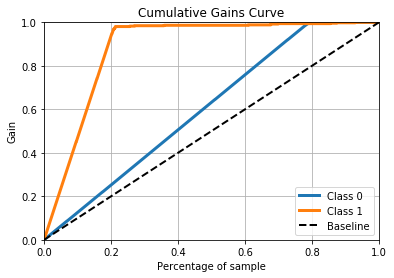

In [62]:
plot_cumulative_gain(y_test, y_score)
plt.show()

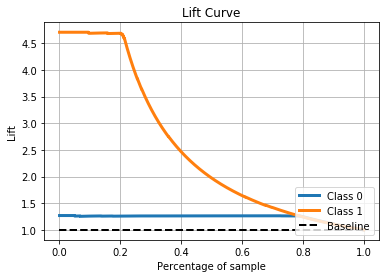

In [63]:
plot_lift_curve(y_test, y_score)
plt.show()